*******
<div style="padding:20px;color:black;margin:0;font-size:200%;text-align:center;display:fill;border-radius:5px;background-color:#bdd6f5;overflow:hidden;font-weight:500">Prédiction de la consommation d'énergie des bâtiments publiques à Seattle</div>

*******

### Tables des matières<a class="anchor" id="retour"></a>

[Présentation de la partie 2](#Présentation)


* [Partie 2 🛠 Machine Learning (Régression) ](#Partie_2)

    * [2.1 Régression lineaire comme baseline](#Section_2.1)
    * [2.2 Régression linéaire sur données centrées réduite](#Section_2.2)
    * [2.3 Régression Ridge ](#Section_2.3)
    * [2.4 Régression LASSO ](#Section_2.4)
    * [2.5 Régression sur les 3 premières composantes principales ](#Section_2.5)
    * [2.6 Régression linéaire sur données en log ](#Section_2.6)
    * [2.7 Gradient Boosting regressor sur données en log (Scikit Learn) ](#Section_2.7)
    * [2.8 XGBoost](#Section_2.8)
    * [2.9 XGBoost (avec ENERGYSTARScore)](#Section_2.9)


[Conclusion partie 2](#Conclusion)

[Références](#Références)

In [337]:
# Importation des librairies

import pandas as pd
import numpy as np

# Lib pour réaliser des graphiques
import matplotlib.pyplot as plt
import seaborn as sns

# Lib pour mesurer le temps execution
import time


# Lib pour regression linéaire
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.ensemble import GradientBoostingRegressor
import xgboost
from xgboost import XGBRegressor

# Lib pour séparer les données en 2 set
from sklearn.model_selection import train_test_split

# Lib pour travailler sur les données CR
from sklearn import preprocessing
from sklearn.decomposition import PCA
import sklearn.decomposition

# Lib pour réccupérer le RMSE
from sklearn.metrics import mean_squared_error

# Lib pour l'imputation des données manquantes (algorythme des KNN)
from sklearn.impute import KNNImputer

# Lib pour le passage en log
import math

# Lib pour le gridsearch et les métriques
from sklearn.model_selection import GridSearchCV
from sklearn import  metrics

****
<div style="padding:20px;color:black;margin:0;font-size:200%;display:fill;border-radius:5px;background-color:#e9f1fc;overflow:hidden;font-weight:500">Partie 2 🛠 Machine Learning (Régression)</div>
<a class="anchor" id="Partie_2"></a>

****

## Présentation partie 2
<a class="anchor" id="Partie_2"></a>

In [338]:
# Importation des données
df = pd.read_csv("df.csv",sep=";")
df_float = pd.read_csv("df_float.csv",sep=";")
df_objet = pd.read_csv("df_objet.csv",sep=";")

In [339]:
# Suppression des colonnes inutiles
df_float = df_float.drop(columns=["Unnamed: 0"])
df_objet = df_objet.drop(columns=["Unnamed: 0"])
df = df.drop(columns=["Unnamed: 0"])

In [340]:
target=df[["SiteEnergyUse(kBtu)"]]

### Création de fonctions

In [341]:
# Création d'une fonction qui renvoit le RMSE

def rmse(X_test,pred):
    MSE = mean_squared_error(y_test, pred.prediction)
    RMSE = math.sqrt(MSE)
    return print(RMSE)

In [342]:
# Création d'une fonction qui passe un df au log

def df_au_log(data_1):
    val = np.log(data_1.values)
    data_2 = pd.DataFrame(data=val,columns=data_1.columns,index=data_1.index)
    return data_2

In [343]:
# Création d'une fonction composé des coeff de la regression triés par ordre en valeur absolue

def coef_sort(model):
    coef = pd.DataFrame(data=model.coef_,columns=df_float.columns)
    coef = pd.DataFrame(data=coef.transpose().values,columns=["coeff"],
                        index=coef.transpose().index)
    coef["coeff_sort"] = coef["coeff"].abs()
    coef = coef.sort_values(by="coeff_sort",ascending=False)
    return coef

## 2.1) Régression linéaire comme baseline
<a class="anchor" id="Section_2.1"></a>

In [344]:
# Création de quatre DF: train et test
X_train, X_test, y_train, y_test = train_test_split(df_float, target, test_size=0.3, random_state=0)

# Régression linéaire
tps1 = time.time()
model = LinearRegression().fit(X_train, y_train)
tps2 = time.time()
temps = tps2 - tps1
print("Temps de calcul : ",temps,"ms")

Temps de calcul :  0.015584945678710938 ms


### Métriques R2 & RMSE
### Représentation graphique des coefficients et du pouvoir prédictif du modèle

In [345]:
print("R2 sur le set d'apprentissage: ",model.score(X_train, y_train),"\n",
    "R2 sur le set de test: ",model.score(X_test, y_test))

R2 sur le set d'apprentissage:  0.5693850347422478 
 R2 sur le set de test:  0.69574589592203


In [346]:
# Création d'un DF des valeurs prédites de X_test
pred = model.predict(X_test)
pred = pd.DataFrame(pred,columns=["prediction"])
pred

# Affichage du RMSE
rmse(X_test,pred)

19110987.421397418


In [347]:
# Création d'un DF composée de la target la prédiction et les résidus

y_model = y_test.merge(df_float["PropertyGFATotal"],how="left",left_index=True,right_index=True)
y_model = pd.DataFrame(y_model).reset_index()
y_model = y_model.drop(columns=["index"])
pred = pd.concat([y_model[["SiteEnergyUse(kBtu)","PropertyGFATotal"]],pred],axis=1)
pred["residus"] = pred["SiteEnergyUse(kBtu)"]-pred["prediction"]
pred

,SiteEnergyUse(kBtu),PropertyGFATotal,prediction,residus
0,1.053291e+06,56340,2.223676e+06,-1.170386e+06
1,6.697878e+05,30796,3.030953e+05,3.666926e+05
2,4.885154e+05,23177,-6.489223e+05,1.137438e+06
3,2.871325e+05,25000,1.565692e+06,-1.278560e+06
4,1.678459e+06,20539,1.193146e+06,4.853130e+05
...,...,...,...,...
1000,1.388812e+06,55842,2.345933e+06,-9.571213e+05
1001,1.746374e+07,526423,3.498826e+07,-1.752451e+07
1002,3.696785e+06,40329,8.957360e+05,2.801049e+06
1003,1.004643e+07,220018,8.656061e+06,1.390373e+06


Text(0.5, 1.0, 'Prédiction de 97% des points')

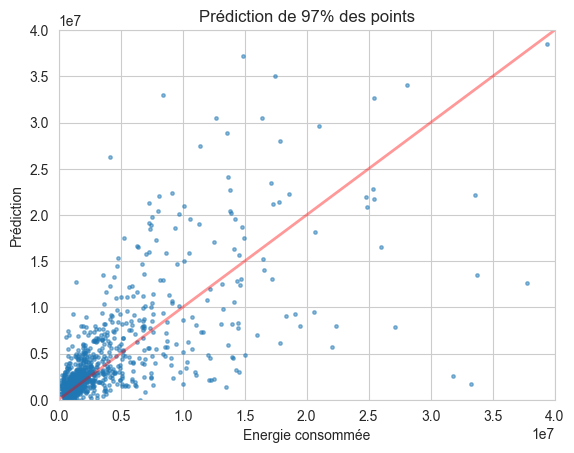

In [348]:
# Représentation graphique de la prédiction
axes = plt.gca()
plt.scatter(data=pred, x="SiteEnergyUse(kBtu)", y="prediction",alpha=0.5,s=6)
plt.plot([0.0, 40_000_000], [0.0, 40_000_000], 'r-', lw=2,alpha=0.4)

plt.xlim(0, 40_000_000)
plt.ylim(0, 40_000_000)

axes.set_xlabel('Energie consommée')
axes.set_ylabel('Prédiction')

plt.title('Prédiction de 97% des points')

In [350]:
# Création d'un DF composé des coeff de la regression
coef = coef_sort(model)
coef

,coeff,coeff_sort
NumberofBuildings,2.113215e+06,2.113215e+06
tx_gaz,1.175494e+06,1.175494e+06
BulType,5.161592e+05,5.161592e+05
NumberofFloors,-1.934993e+05,1.934993e+05
Council,-8.799675e+04,8.799675e+04
PPT,-5.629667e+04,5.629667e+04
Voisin,-2.219450e+04,2.219450e+04
Zip,-1.201552e+04,1.201552e+04
years,1.107696e+04,1.107696e+04
ThirdLargestPropertyUseTypeGFA,-7.152262e+01,7.152262e+01


Text(0.5, 1.0, 'Coefficients de regression')

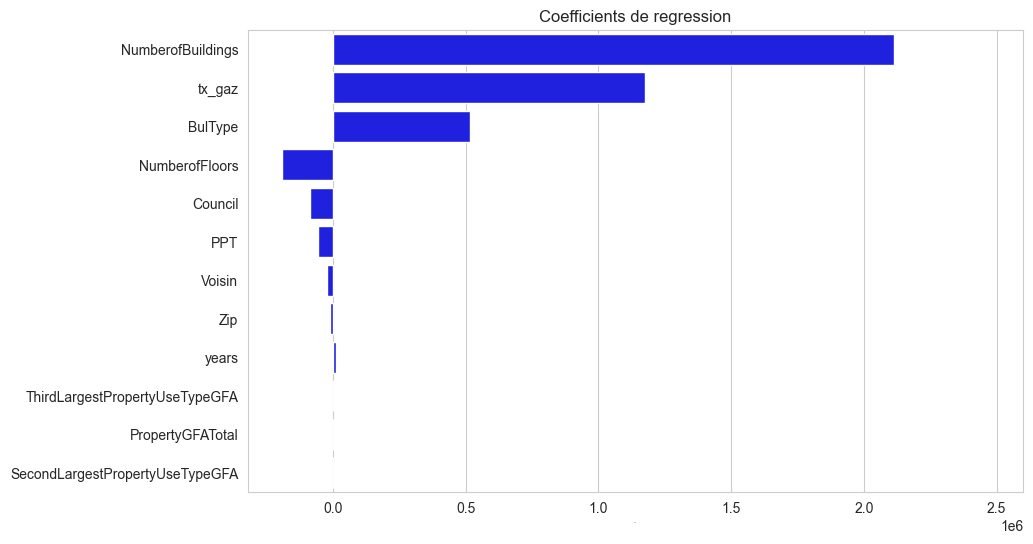

In [351]:
# Bar Plot des coeff

fig, ax = plt.subplots(figsize=(10, 6))

ax.set_xlim(-320_000, 2_600_000)
ax.set_xlabel( "",size=0 )
sns.barplot(x =coef.coeff  , y =coef.index ,data = coef , color = 'b',orient='h')
plt.setp(ax.get_yticklabels(),fontsize = 10)
plt.title("Coefficients de regression")

In [442]:
df_float["NumberofBuildings"].value_counts()

1.0     3246
2.0       37
3.0       22
4.0       12
5.0       10
6.0        4
8.0        3
14.0       2
10.0       2
27.0       1
11.0       1
16.0       1
23.0       1
9.0        1
Name: NumberofBuildings, dtype: int64

## 2.2) Régression linéaire sur données centrées réduites
<a class="anchor" id="Section_2.2"></a>

Le modèle n'a pas l'air capable de prédire les 10 plus grandes valeur de la target.
Nous ne les conservons pas pour vérifier si le modèle est plus performant.
De plus nous travaillons dans cette partie sur les données centrées réduites

In [352]:
# Création d'un DF ne contenant plus les 5 valeurs les plus grandes

df_cr = pd.concat([target,df_float],axis=1)
df_cr = df_cr[df_cr["SiteEnergyUse(kBtu)"]<200_000_000]

df_float = df_cr.drop(columns=["SiteEnergyUse(kBtu)"])
target = df_cr[["SiteEnergyUse(kBtu)"]]


# Données centrées réduite sur toute la table entière

std_scale = preprocessing.StandardScaler().fit(df_float)
df_float_cr = std_scale.transform(df_float)

std_scale = preprocessing.StandardScaler().fit(target)
target_cr =  std_scale.transform(target)

# Permet d'avoir en output du modèle un DF
target_cr = pd.DataFrame(data=target_cr,columns=["SiteEnergyUse(kBtu)"],index=target.index)
df_float_cr = pd.DataFrame(data=df_float_cr,columns=df_float.columns,index=df_float.index)

# Création de quatre DF: train et test
X_train, X_test, y_train, y_test = train_test_split(df_float_cr, target_cr,
                                                    test_size=0.3, random_state=0)

# Régression linéaire
tps1 = time.time()
model_cr = LinearRegression().fit(X_train, y_train)
tps2 = time.time()
temps_cr = tps2 - tps1
print("Temps de calcul : ",temps_cr,"ms")

Temps de calcul :  0.003957509994506836 ms


### Métriques R2 & RMSE
### Représentation graphique des coefficients et du pouvoir prédictif du modèle

In [353]:
print("R2 sur le set d'apprentissage: ",model_cr.score(X_train, y_train),"\n",
    "R2 sur le set de test: ",model_cr.score(X_test, y_test))

R2 sur le set d'apprentissage:  0.6134585465721172 
 R2 sur le set de test:  0.4422703884289232


In [354]:
# Création d'un DF des valeurs prédites de X_test
pred = model_cr.predict(X_test)
pred=pd.DataFrame(pred,columns=["prediction"])

# Affichage du RMSE
rmse(X_test,pred)

0.8566063983297295


In [355]:
# Création d'un DF composée de la target la prédiction et les résidus

y_cr = y_test.merge(df_float_cr["PropertyGFATotal"],how="left",left_index=True,right_index=True)
y_cr = pd.DataFrame(y_cr).reset_index()
y_cr = y_cr.drop(columns=["index"])
pred = pd.concat([y_cr[["SiteEnergyUse(kBtu)","PropertyGFATotal"]],pred],axis=1)
pred["residus"] = pred["SiteEnergyUse(kBtu)"]-pred["prediction"]
pred


,SiteEnergyUse(kBtu),PropertyGFATotal,prediction,residus
0,-0.417141,-0.456544,-0.401408,-0.015733
1,-0.428199,-0.483138,-0.396542,-0.031657
2,-0.260279,-0.307297,-0.163046,-0.097233
3,-0.326544,-0.243394,-0.085312,-0.241232
4,-0.318308,-0.222790,-0.058539,-0.259769
...,...,...,...,...
998,-0.358892,-0.441438,-0.434538,0.075646
999,0.136396,-0.415501,-0.341645,0.478041
1000,-0.340402,-0.267084,-0.164762,-0.175639
1001,0.003858,0.173982,0.092783,-0.088924


Text(0.5, 1.0, 'Prédiction de 97% des points')

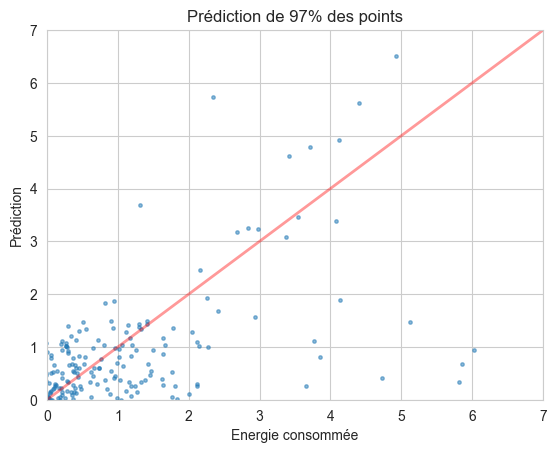

In [356]:
# Graphique de la target et de la prédiction
axes = plt.gca()
plt.scatter(data=pred, x="SiteEnergyUse(kBtu)", y="prediction",alpha=0.5,s=6)
plt.plot([0.0, 7], [0.0, 7], 'r-', lw=2,alpha=0.4)

plt.xlim(0, 7)
plt.ylim(0, 7)

axes.set_xlabel('Energie consommée')
axes.set_ylabel('Prédiction')

plt.title('Prédiction de 97% des points')

In [357]:
# Création d'un DF composé des coeff de la regression
coef = coef_sort(model_cr)
coef

,coeff,coeff_sort
PropertyGFATotal,0.702121,0.702121
NumberofBuildings,0.104642,0.104642
tx_gaz,0.051890,0.051890
BulType,0.038603,0.038603
Zip,-0.024038,0.024038
ThirdLargestPropertyUseTypeGFA,0.022357,0.022357
years,0.019278,0.019278
NumberofFloors,-0.015163,0.015163
Voisin,-0.012907,0.012907
Council,0.010707,0.010707


Text(0.5, 1.0, 'Coefficients de regression')

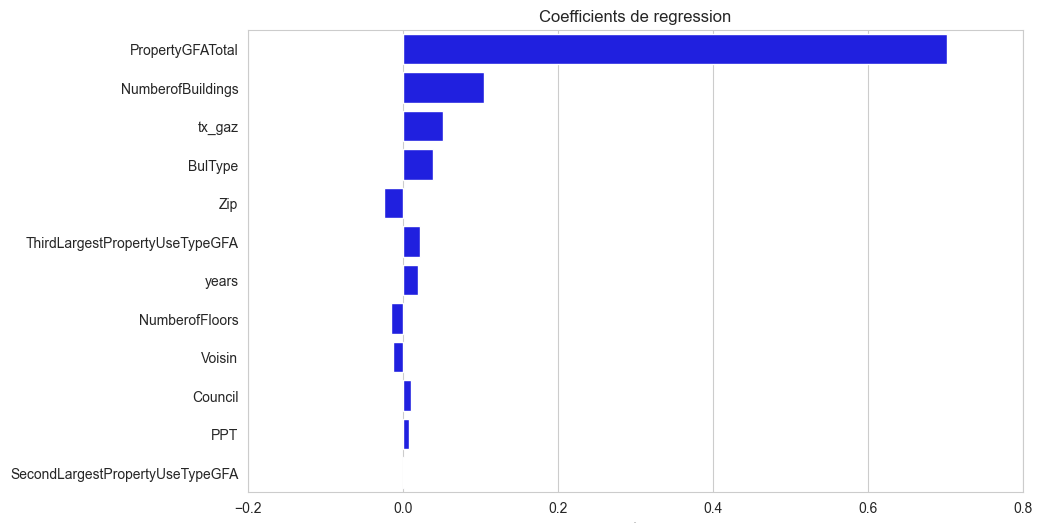

In [358]:
# Graphique des coeff
fig, ax = plt.subplots(figsize=(10, 6))

ax.set_xlim(-0.2, 0.8)
ax.set_xlabel( "",size=0 )
sns.barplot(x =coef.coeff  , y =coef.index ,data = coef , color = 'b',orient='h')
plt.setp(ax.get_yticklabels(),fontsize = 10)
plt.title("Coefficients de regression")

## 2.3) Régression Ridge
<a class="anchor" id="Section_2.3"></a>

Regression Ridge sur les données centrées réduites.
Utilisation d'un gridsearch afin de tester plusieurs hyperparamètre

In [359]:
# Création de quatre DF: train et test
X_train, X_test, y_train, y_test = train_test_split(df_float_cr, target_cr, test_size=0.3, random_state=0)

In [360]:
# Modèle RIDGE

tps1 = time.time()

score="r2"
param_grid = { "alpha":[0.2,0.4,0.6,0.8,0.9,2,5,9,10,11,12,50,100]}

model_ridge = GridSearchCV( Ridge(),
                            param_grid,
                            cv=10,
                            scoring=score )

model_ridge.fit(X_train,y_train)

tps2 = time.time()
temps_ridge = tps2 - tps1
print("Temps de calcul : ",temps_ridge,"ms")

Temps de calcul :  2.396211862564087 ms


In [361]:
# Afficher le(s) hyperparamètre(s) optimaux
print("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:")
print(model_ridge.best_params_)

Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'alpha': 100}


In [362]:
# Afficher les performances correspondantes

result = "mean_test_score"
print("Résultats de la validation croisée :")
for mean, std, params in zip(
        model_ridge.cv_results_['mean_test_score'], # score moyen
        model_ridge.cv_results_['std_test_score'],  # écart-type du score
        model_ridge.cv_results_['params'] ):          # valeur de l'hyperparamètre

    print("{} = {:.3f} (+/-{:.03f}) for {}".format( result,
                                                    mean,
                                                    std*2,
                                                    params ) )

Résultats de la validation croisée :
mean_test_score = 0.593 (+/-0.179) for {'alpha': 0.2}
mean_test_score = 0.593 (+/-0.179) for {'alpha': 0.4}
mean_test_score = 0.593 (+/-0.179) for {'alpha': 0.6}
mean_test_score = 0.593 (+/-0.179) for {'alpha': 0.8}
mean_test_score = 0.593 (+/-0.179) for {'alpha': 0.9}
mean_test_score = 0.594 (+/-0.179) for {'alpha': 2}
mean_test_score = 0.594 (+/-0.179) for {'alpha': 5}
mean_test_score = 0.594 (+/-0.178) for {'alpha': 9}
mean_test_score = 0.594 (+/-0.178) for {'alpha': 10}
mean_test_score = 0.594 (+/-0.178) for {'alpha': 11}
mean_test_score = 0.594 (+/-0.178) for {'alpha': 12}
mean_test_score = 0.596 (+/-0.178) for {'alpha': 50}
mean_test_score = 0.597 (+/-0.178) for {'alpha': 100}


In [363]:
model_ridge.best_estimator_

Ridge(alpha=100)

In [364]:
reg_ridge= Ridge(alpha=0.2)
reg_ridge.fit(X_train,y_train)

Ridge(alpha=0.2)

In [365]:
# Création d'un DF composé des coeff de la regression
coef = coef_sort(reg_ridge)
coef

,coeff,coeff_sort
PropertyGFATotal,0.701943,0.701943
NumberofBuildings,0.104653,0.104653
tx_gaz,0.051888,0.051888
BulType,0.038615,0.038615
Zip,-0.024035,0.024035
ThirdLargestPropertyUseTypeGFA,0.022373,0.022373
years,0.019272,0.019272
NumberofFloors,-0.015092,0.015092
Voisin,-0.012907,0.012907
Council,0.010701,0.010701


Text(0.5, 1.0, 'Coefficients de regression')

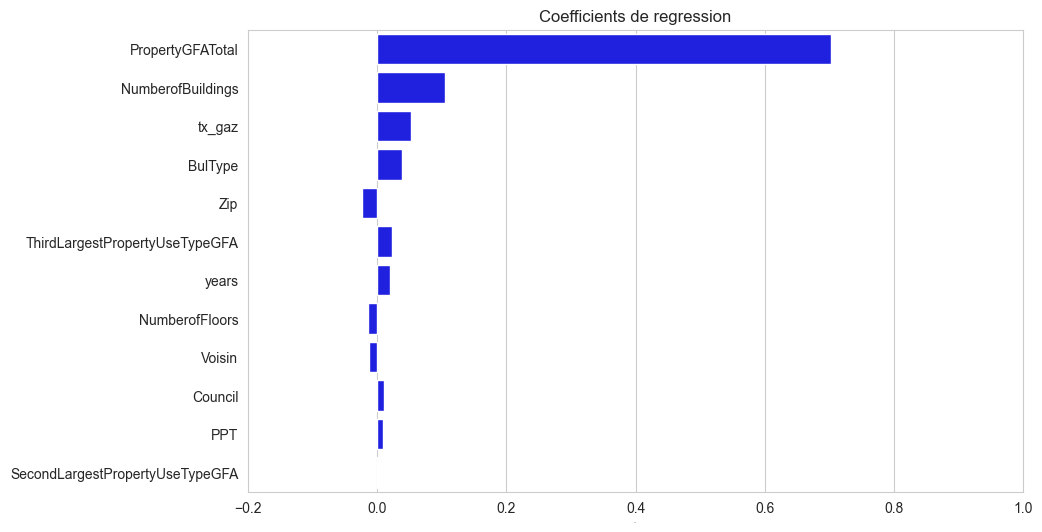

In [366]:
# Représentation graphique des coefficients

fig, ax = plt.subplots(figsize=(10, 6))
ax.set_xlim(-0.2,1)
ax.set_xlabel( "",size=0 )
sns.barplot(x =coef.coeff  , y =coef.index ,data = coef , color = 'b',orient='h')
plt.setp(ax.get_yticklabels(),fontsize = 10)
plt.title("Coefficients de regression")

### Métriques R2 & RMSE
### Représentation graphique des coefficients et du pouvoir prédictif du modèle

In [367]:
print("R2 sur le set d'apprentissage: ",model_ridge.score(X_train, y_train),"\n",
    "R2 sur le set de test: ",model_ridge.score(X_test, y_test))

R2 sur le set d'apprentissage:  0.6112629686077224 
 R2 sur le set de test:  0.4390180063878455


In [368]:
# Création d'un DF des valeurs prédites de X_test
pred = model_ridge.predict(X_test)
pred = pd.DataFrame(pred,columns=["prediction"])

# Affichage du RMSE
rmse(X_test,pred)

0.8591004038251142


In [369]:
# Création d'un DF composée de la target la prédiction et les résidus

y_ridge = y_test.merge(df_float_cr["PropertyGFATotal"],how="left",left_index=True,right_index=True)
y_ridge = pd.DataFrame(y_ridge).reset_index()
y_ridge=y_ridge.drop(columns=["index"])
pred = pd.concat([y_ridge[["SiteEnergyUse(kBtu)","PropertyGFATotal"]],pred],axis=1)
pred["residus"]=pred["SiteEnergyUse(kBtu)"]-pred["prediction"]
pred

,SiteEnergyUse(kBtu),PropertyGFATotal,prediction,residus
0,-0.417141,-0.456544,-0.377191,-0.039950
1,-0.428199,-0.483138,-0.387795,-0.040403
2,-0.260279,-0.307297,-0.166292,-0.093986
3,-0.326544,-0.243394,-0.080578,-0.245966
4,-0.318308,-0.222790,-0.069970,-0.248338
...,...,...,...,...
998,-0.358892,-0.441438,-0.421780,0.062889
999,0.136396,-0.415501,-0.331703,0.468099
1000,-0.340402,-0.267084,-0.166526,-0.173876
1001,0.003858,0.173982,0.116500,-0.112642


Text(0.5, 1.0, 'Prédiction de 97% des points')

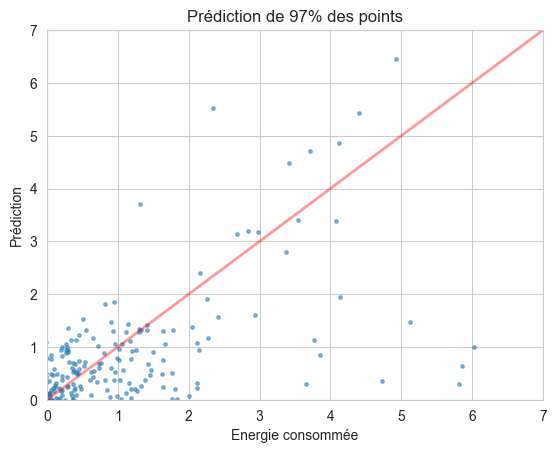

In [370]:
# Graphique de la target et de la prédiction
axes = plt.gca()
plt.scatter(data=pred, x="SiteEnergyUse(kBtu)", y="prediction",alpha=0.5,s=6)
plt.plot([0.0, 7], [0.0, 7], 'r-', lw=2,alpha=0.4)

plt.xlim(0, 7)
plt.ylim(0, 7)

axes.set_xlabel('Energie consommée')
axes.set_ylabel('Prédiction')

plt.title('Prédiction de 97% des points')

La régression Ridge n'a pas amélioré le pouvoir prédictif du modèle

## 2.4) Régression LASSO
<a class="anchor" id="Section_2.4"></a>

In [371]:
# Création de quatre DF: train et test
X_train, X_test, y_train, y_test = train_test_split(df_float_cr, target_cr,
                                                    test_size=0.3, random_state=0)

In [372]:
# Modèle LASSO
tps1 = time.time()

score="r2"
param_grid = { "alpha":[0.1,0.2,0.4,0.6,0.8,0.9,2,5,9,10,11,12,50,100]}

model_lasso = GridSearchCV( Lasso(),
                      param_grid,
                      cv=10,
                      scoring=score)

model_lasso.fit(X_train,y_train)

tps2 = time.time()
temps_lasso = tps2 - tps1
print("Temps de calcul : ",temps_lasso,"ms")

Temps de calcul :  0.7007715702056885 ms


In [373]:
# Afficher le(s) hyperparamètre(s) optimaux
print("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:")
print(model_lasso.best_params_)

Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'alpha': 0.1}


In [374]:
# Afficher les performances correspondantes

result = 'mean_test_score'
print("Résultats de la validation croisée :")
for mean, std, params in zip(
        model_lasso.cv_results_['mean_test_score'], # score moyen
        model_lasso.cv_results_['std_test_score'],  # écart-type du score
        model_lasso.cv_results_['params'] ):          # valeur de l'hyperparamètre

    print("{} = {:.3f} (+/-{:.03f}) pour {}".format( result,
                                                     mean,
                                                     std*2,
                                                     params) )

Résultats de la validation croisée :
mean_test_score = 0.598 (+/-0.213) pour {'alpha': 0.1}
mean_test_score = 0.569 (+/-0.232) pour {'alpha': 0.2}
mean_test_score = 0.430 (+/-0.201) pour {'alpha': 0.4}
mean_test_score = 0.186 (+/-0.093) pour {'alpha': 0.6}
mean_test_score = -0.004 (+/-0.009) pour {'alpha': 0.8}
mean_test_score = -0.004 (+/-0.009) pour {'alpha': 0.9}
mean_test_score = -0.004 (+/-0.009) pour {'alpha': 2}
mean_test_score = -0.004 (+/-0.009) pour {'alpha': 5}
mean_test_score = -0.004 (+/-0.009) pour {'alpha': 9}
mean_test_score = -0.004 (+/-0.009) pour {'alpha': 10}
mean_test_score = -0.004 (+/-0.009) pour {'alpha': 11}
mean_test_score = -0.004 (+/-0.009) pour {'alpha': 12}
mean_test_score = -0.004 (+/-0.009) pour {'alpha': 50}
mean_test_score = -0.004 (+/-0.009) pour {'alpha': 100}


In [375]:
# Afficher le(s) hyperparamètre(s) optimaux
print("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:")
print(model_lasso.best_params_)

Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'alpha': 0.1}


### Métriques R2 & RMSE
### Représentation graphique des coefficients et du pouvoir prédictif du modèle

In [376]:
# Création d'un DF des valeurs prédites de X_test
pred = model_lasso.predict(X_test)
pred = pd.DataFrame(pred,columns=["prediction"])

# Affichage du RMSE
rmse(X_test,pred)

0.8860937031542888


In [377]:
print("R2 sur le set d'apprentissage: ",model_lasso.score(X_train, y_train),"\n",
    "R2 sur le set de test: ",model_lasso.score(X_test, y_test))

R2 sur le set d'apprentissage:  0.5854786745764325 
 R2 sur le set de test:  0.4032115961102126


In [378]:
reg_lasso = Lasso(alpha=0.2)
reg_lasso.fit(X_train,y_train)

Lasso(alpha=0.2)

In [379]:
# Création d'un DF composée de la target la prédiction et les résidus

y_lasso = y_test.merge(df_float_cr["PropertyGFATotal"],how="left",left_index=True,right_index=True)
y_lasso = pd.DataFrame(y_lasso).reset_index()
y_lasso=y_lasso.drop(columns=["index"])
pred = pd.concat([y_lasso[["SiteEnergyUse(kBtu)","PropertyGFATotal"]],pred],axis=1)
pred["residus"]=pred["SiteEnergyUse(kBtu)"]-pred["prediction"]
pred

,SiteEnergyUse(kBtu),PropertyGFATotal,prediction,residus
0,-0.417141,-0.456544,-0.296167,-0.120974
1,-0.428199,-0.483138,-0.312505,-0.115693
2,-0.260279,-0.307297,-0.204480,-0.055799
3,-0.326544,-0.243394,-0.165222,-0.161322
4,-0.318308,-0.222790,-0.152564,-0.165744
...,...,...,...,...
998,-0.358892,-0.441438,-0.286887,-0.072004
999,0.136396,-0.415501,-0.270953,0.407349
1000,-0.340402,-0.267084,-0.179775,-0.160626
1001,0.003858,0.173982,0.091187,-0.087329


Text(0.5, 1.0, 'Prédiction de 97% des points')

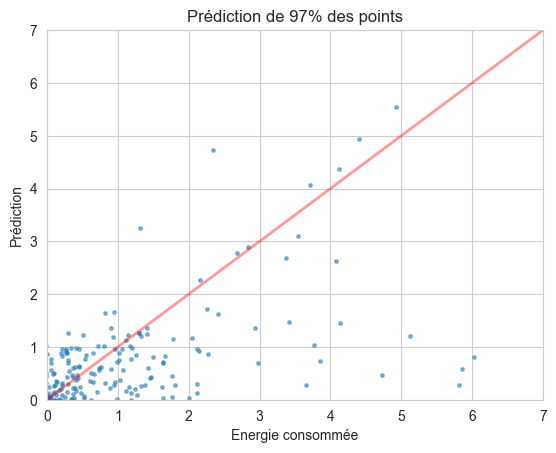

In [380]:
# Graphique de la target et de la prédiction
axes = plt.gca()
plt.scatter(data=pred, x="SiteEnergyUse(kBtu)", y="prediction",alpha=0.5,s=6)
plt.plot([0.0, 7], [0.0, 7], 'r-', lw=2,alpha=0.4)

plt.xlim(0, 7)
plt.ylim(0, 7)

axes.set_xlabel('Energie consommée')
axes.set_ylabel('Prédiction')

plt.title('Prédiction de 97% des points')

In [381]:
# Création d'un DF composé des coefficients

coef = pd.DataFrame(data=reg_lasso.coef_, columns = ["coeff"],index=df_float_cr.columns)
coef["coeff_sort"] = coef["coeff"].abs()
coef = coef.sort_values(by="coeff_sort",ascending=False)
coef

,coeff,coeff_sort
PropertyGFATotal,0.515771,0.515771
years,0.000000,0.000000
NumberofFloors,0.000000,0.000000
NumberofBuildings,0.000000,0.000000
SecondLargestPropertyUseTypeGFA,0.000000,0.000000
ThirdLargestPropertyUseTypeGFA,0.000000,0.000000
tx_gaz,0.000000,0.000000
BulType,0.000000,0.000000
PPT,0.000000,0.000000
Zip,-0.000000,0.000000


Text(0.5, 1.0, 'Coefficients de regression')

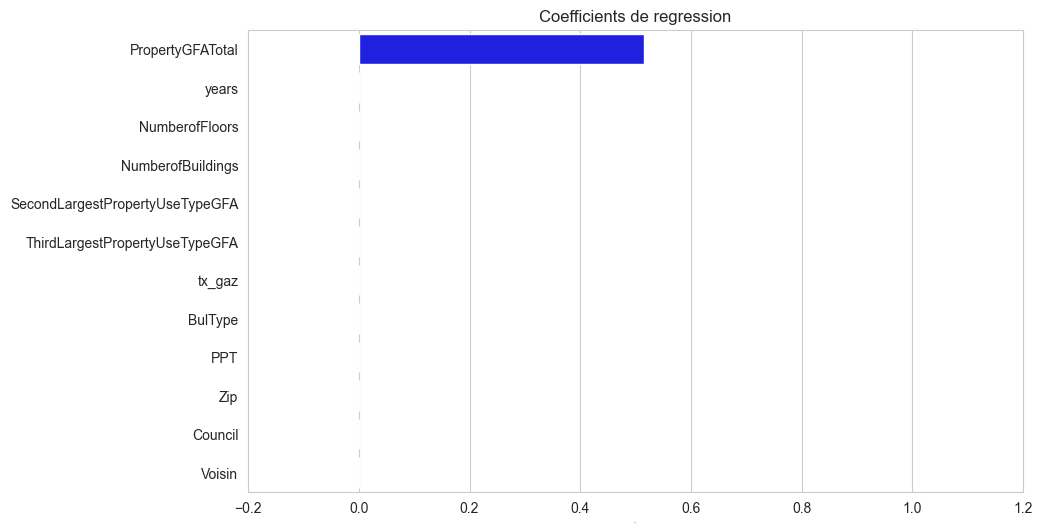

In [382]:
# Représentation graphique des coefficients

fig, ax = plt.subplots(figsize=(10, 6))
ax.set_xlim(-0.2, 1.2)
ax.set_xlabel( "",size=0 )
sns.barplot(x =coef.coeff  , y =coef.index ,data = coef , color = 'b',orient='h')
plt.setp(ax.get_yticklabels(),fontsize = 10)
plt.title("Coefficients de regression")

La régression LASSO montre toute son utilité:
- une seule variable permet d'expliquer le modèle
- la pénalité est efficace

## 2.5) Regression sur les 3 premieres composantes principales
<a class="anchor" id="Section_2.5"></a>

In [383]:
liste_r2=[]
liste_var=[]

for i in range(1,12):
    pca = PCA(n_components=i)
    pca.fit(df_float_cr)
    df_pca = pca.fit_transform(df_float_cr)

    X_train, X_test, y_train, y_test = train_test_split(df_pca, target_cr,
                                                    test_size=0.3, random_state=0)

    model_pca = LinearRegression().fit(X_train, y_train)

    liste_r2.append(model_pca.score(X_test, y_test))
    liste_var.append(pca.explained_variance_ratio_.sum())

print(liste_r2,"\n",liste_var)

[0.30014521676710393, 0.3179613241103558, 0.33224750369442235, 0.37275871006749794, 0.37229908973891457, 0.37367057692525696, 0.374035315643648, 0.38102318975564453, 0.3906772145035451, 0.3936276299514606, 0.400239965983462] 
 [0.23573286478532796, 0.3652115582053753, 0.48094880555255554, 0.5687974491222706, 0.6479861754562637, 0.7191473108062384, 0.7863125057914029, 0.8490940274401689, 0.9011785987261552, 0.9490914238126098, 0.983425598194352]


In [384]:
pca = PCA(n_components=3)
pca.fit(df_float_cr)

PCA(n_components=3)

In [385]:
pca.explained_variance_ratio_.sum()

0.48094880555255476

In [386]:
# Création d'un DF ne contenant plus les 5 valeurs les plus grandes
df_pca = pca.fit_transform(df_float_cr)

In [387]:
# Création d'un DF ne contenant plus les 5 valeurs les plus grandes

# Création de quatre DF: train et test
X_train, X_test, y_train, y_test = train_test_split(df_pca, target_cr,
                                                    test_size=0.3, random_state=0)

# Régression linéaire
tps1 = time.time()
model_pca = LinearRegression().fit(X_train, y_train)
tps2 = time.time()
temps_pca = tps2 - tps1
print("Temps de calcul : ",temps_pca,"ms")

Temps de calcul :  0.003988504409790039 ms


### Métriques R2 & RMSE
### Représentation graphique des coefficients et du pouvoir prédictif du modèle

In [388]:
print("R2 sur le set d'apprentissage: ",model_pca.score(X_train, y_train),"\n",
    "R2 sur le set de test: ",model_pca.score(X_test, y_test))

R2 sur le set d'apprentissage:  0.4799937656851354 
 R2 sur le set de test:  0.33224750369442246


In [389]:
# Création d'un DF des valeurs prédites de X_test
pred = model_pca.predict(X_test)
pred=pd.DataFrame(pred,columns=["prediction"])

# Affichage du RMSE
rmse(X_test,pred)

0.9372969904291802


In [390]:
# Création d'un DF composée de la target la prédiction et les résidus

y_pca = y_test.merge(df_float_cr["PropertyGFATotal"],how="left",left_index=True,right_index=True)
y_pca = pd.DataFrame(y_pca).reset_index()
y_pca = y_pca.drop(columns=["index"])
pred = pd.concat([y_pca[["SiteEnergyUse(kBtu)","PropertyGFATotal"]],pred],axis=1)
pred["residus"] = pred["SiteEnergyUse(kBtu)"]-pred["prediction"]
pred

,SiteEnergyUse(kBtu),PropertyGFATotal,prediction,residus
0,-0.417141,-0.456544,-0.208031,-0.209110
1,-0.428199,-0.483138,-0.364973,-0.063226
2,-0.260279,-0.307297,-0.374238,0.113959
3,-0.326544,-0.243394,0.191514,-0.518057
4,-0.318308,-0.222790,-0.229184,-0.089124
...,...,...,...,...
998,-0.358892,-0.441438,-0.501260,0.142369
999,0.136396,-0.415501,-0.152603,0.288999
1000,-0.340402,-0.267084,-0.366249,0.025847
1001,0.003858,0.173982,0.370278,-0.366420


Text(0.5, 1.0, 'Prédiction de 97% des points')

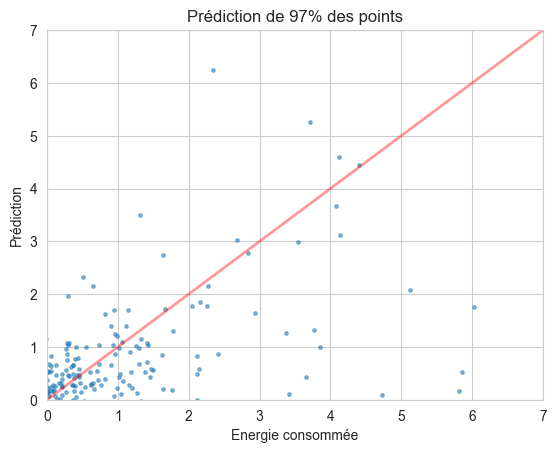

In [391]:
# Graphique de la target et de la prédiction
axes = plt.gca()
plt.scatter(data=pred, x="SiteEnergyUse(kBtu)", y="prediction",alpha=0.5,s=6)
plt.plot([0.0, 7], [0.0, 7], 'r-', lw=2,alpha=0.4)

plt.xlim(0, 7)
plt.ylim(0, 7)

axes.set_xlabel('Energie consommée')
axes.set_ylabel('Prédiction')

plt.title('Prédiction de 97% des points')

In [392]:
# Création d'une fonction composé des coeff de la regression triés par ordre en valeur absolue
df_pca = pd.DataFrame(data=df_pca,columns=["comp_1","comp_2","comp_3"])
coef = pd.DataFrame(data=model_pca.coef_,columns=df_pca.columns)
coef = pd.DataFrame(data=coef.transpose().values,columns=["coeff"],
                        index=coef.transpose().index)
coef["coeff_sort"] = coef["coeff"].abs()
coef = coef.sort_values(by="coeff_sort",ascending=False)
coef

,coeff,coeff_sort
comp_1,0.366749,0.366749
comp_2,0.139293,0.139293
comp_3,0.095037,0.095037


Text(0.5, 1.0, 'Coefficients de regression')

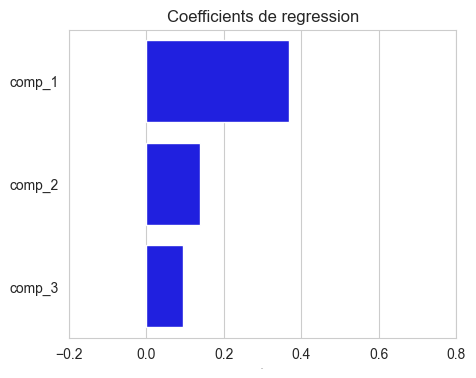

In [393]:
# Graphique des coeff

fig, ax = plt.subplots(figsize=(5, 4))
ax.set_xlim(-0.2, 0.8)
ax.set_xlabel( "",size=0 )
sns.barplot(x =coef.coeff  , y =coef.index ,data = coef , color = 'b',orient='h')
plt.setp(ax.get_yticklabels(),fontsize = 10)
plt.title("Coefficients de regression")

## 2.6) Régression sur le log des données
<a class="anchor" id="Section_2.6"></a>

In [394]:
# Transformation des DF en log

df_float[df_float==0]=1
df_float_log = df_au_log(df_float)

target[target==0]=1
target_log = df_au_log(target)

C:\Users\fbbou\AppData\Local\Temp\ipykernel_5728\277867087.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target[target==0]=1
C:\Users\fbbou\AppData\Local\Temp\ipykernel_5728\277867087.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target[target==0]=1


In [395]:
# Création de quatre DF: train et test
X_train, X_test, y_train, y_test = train_test_split(df_float_log, target_log, test_size=0.3, random_state=0)

# Régression linéaire
tps1 = time.time()
model_log = LinearRegression().fit(X_train, y_train)
tps2 = time.time()
temps_log = tps2 - tps1
print("Temps de calcul : ",temps_log,"ms")

Temps de calcul :  0.0 ms


### Métriques R2 & RMSE
### Représentation graphique des coefficients et du pouvoir prédictif du modèle

In [396]:
print("R2 sur le set d'apprentissage: ",model_log.score(X_train, y_train),"\n",
    "R2 sur le set de test: ",model_log.score(X_test, y_test))

R2 sur le set d'apprentissage:  0.6500335595846105 
 R2 sur le set de test:  0.6569011456711241


In [397]:
# Création d'un DF des valeurs prédites de X_test
pred = model_log.predict(X_test)
pred=pd.DataFrame(pred,columns=["prediction"])

# Affichage du RMSE
rmse(X_test,pred)

0.6748075134948458


In [398]:
# Création d'un DF composée de la target la prédiction et les résidus

y_log = y_test.merge(df_float_log["PropertyGFATotal"],how="left",left_index=True,right_index=True)
y_log = pd.DataFrame(y_log).reset_index()
y_log=y_log.drop(columns=["index"])
pred = pd.concat([y_log[["SiteEnergyUse(kBtu)","PropertyGFATotal"]],pred],axis=1)
pred["residus"]=pred["SiteEnergyUse(kBtu)"]-pred["prediction"]
pred

,SiteEnergyUse(kBtu),PropertyGFATotal,prediction,residus
0,13.344107,10.114397,13.668269,-0.324162
1,13.153030,9.945157,13.545363,-0.392332
2,14.587529,10.742336,14.239211,0.348318
3,14.229982,10.924373,14.912585,-0.682603
4,14.282022,10.976645,14.713781,-0.431759
...,...,...,...,...
998,13.994488,10.199138,13.652969,0.341519
999,15.616972,10.329735,13.995012,1.621960
1000,14.135795,10.860690,14.432896,-0.297101
1001,15.375191,11.660112,15.491205,-0.116015


Text(0.5, 1.0, 'Prédiction de 97% des points')

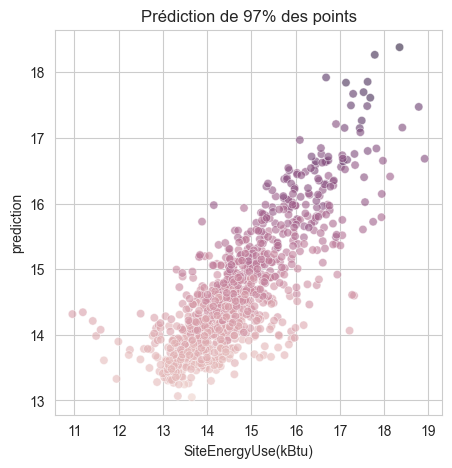

In [399]:
# Graphique de la target et de la prédiction
plt.figure(figsize = (5,5))
sns.scatterplot(data=pred, x="SiteEnergyUse(kBtu)", y="prediction",hue="PropertyGFATotal",
                legend=False,alpha=0.6)
plt.title('Prédiction de 97% des points')

In [400]:
# Création d'un DF composé des coeff de la regression
coef = coef_sort(model_log)
coef

,coeff,coeff_sort
PropertyGFATotal,1.015831,1.015831
BulType,0.296727,0.296727
NumberofBuildings,0.217407,0.217407
Zip,-0.075742,0.075742
years,0.072587,0.072587
tx_gaz,-0.059673,0.059673
Council,0.054414,0.054414
Voisin,-0.049924,0.049924
PPT,-0.038140,0.038140
NumberofFloors,-0.023791,0.023791


Text(0.5, 1.0, 'Coefficients de regression')

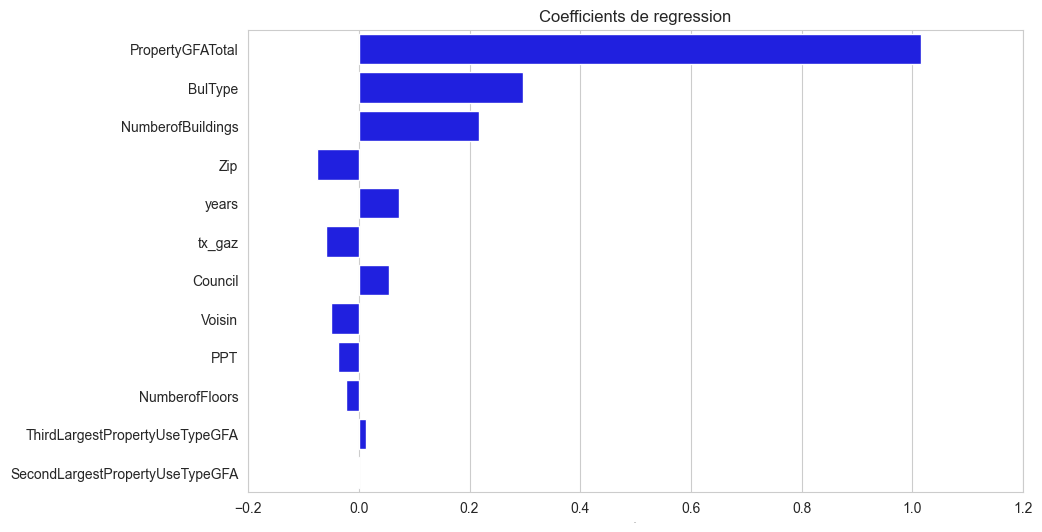

In [401]:
# Représentation graphique des coefficients

fig, ax = plt.subplots(figsize=(10, 6))
ax.set_xlim(-0.2, 1.2)
ax.set_xlabel( "",size=0 )
sns.barplot(x =coef.coeff  , y =coef.index ,data = coef , color = 'b',orient='h')
plt.setp(ax.get_yticklabels(),fontsize = 10)
plt.title("Coefficients de regression")

## 2.7) Gradient Boosting Regressor sur données en log
<a class="anchor" id="Section_2.7"></a>

In [402]:
# Création de quatre DF: train et test
X_train, X_test, y_train, y_test = train_test_split(df_float_log, target_log,
                                                    test_size=0.2, random_state=0)

In [403]:
# Construction du modèle gradient boosting regressor

tps1 = time.time() # Temps d'execution

score ="r2"
param_grid = { "n_estimators":[50,100,200],
               "max_depth":[2,3,5],
               "alpha":[0.2,0.5,0.9]}

model_gbr = GridSearchCV( GradientBoostingRegressor(random_state=0),
                          param_grid,
                          cv = 10,
                          scoring = score)

model_gbr.fit(X_train,y_train)

tps2 = time.time()
temps_gbr = tps2 - tps1
print("Temps de calcul : ",temps_gbr,"ms")

C:\Users\fbbou\PycharmProjects\O-C\Projet_4\venv\lib\site-packages\sklearn\ensemble\_gb.py:570: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\fbbou\PycharmProjects\O-C\Projet_4\venv\lib\site-packages\sklearn\ensemble\_gb.py:570: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\fbbou\PycharmProjects\O-C\Projet_4\venv\lib\site-packages\sklearn\ensemble\_gb.py:570: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\fbbou\PycharmProjects\O-C\Projet_4\venv\lib\site-packages\sklearn\ensemble\_gb.py:570: DataConversionWarning: A column-vector y was pass

Temps de calcul :  126.12174248695374 ms


In [404]:
# Afficher les performances correspondantes

result = "mean_test_score"
print("Résultats de la validation croisée :")
for mean, std, params in zip(
        model_gbr.cv_results_['mean_test_score'], # score moyen
        model_gbr.cv_results_['std_test_score'],  # écart-type du score
        model_gbr.cv_results_['params'] ):          # valeur de l'hyperparamètre

    print("{} = {:.3f} (+/-{:.03f}) for {}".format( result,
                                                   mean,
                                                   std*2,
                                                   params) )

Résultats de la validation croisée :
mean_test_score = 0.720 (+/-0.078) for {'alpha': 0.2, 'max_depth': 2, 'n_estimators': 50}
mean_test_score = 0.747 (+/-0.082) for {'alpha': 0.2, 'max_depth': 2, 'n_estimators': 100}
mean_test_score = 0.760 (+/-0.087) for {'alpha': 0.2, 'max_depth': 2, 'n_estimators': 200}
mean_test_score = 0.743 (+/-0.084) for {'alpha': 0.2, 'max_depth': 3, 'n_estimators': 50}
mean_test_score = 0.757 (+/-0.082) for {'alpha': 0.2, 'max_depth': 3, 'n_estimators': 100}
mean_test_score = 0.767 (+/-0.080) for {'alpha': 0.2, 'max_depth': 3, 'n_estimators': 200}
mean_test_score = 0.749 (+/-0.081) for {'alpha': 0.2, 'max_depth': 5, 'n_estimators': 50}
mean_test_score = 0.753 (+/-0.077) for {'alpha': 0.2, 'max_depth': 5, 'n_estimators': 100}
mean_test_score = 0.751 (+/-0.071) for {'alpha': 0.2, 'max_depth': 5, 'n_estimators': 200}
mean_test_score = 0.720 (+/-0.078) for {'alpha': 0.5, 'max_depth': 2, 'n_estimators': 50}
mean_test_score = 0.747 (+/-0.082) for {'alpha': 0.5, 'ma

In [405]:
# Afficher le(s) hyperparamètre(s) optimaux
print("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:")
print(model_gbr.best_params_)

Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'alpha': 0.2, 'max_depth': 3, 'n_estimators': 200}


In [406]:
gbr = GradientBoostingRegressor( n_estimators=200,
                                max_depth=3,
                                alpha=0.2)
gbr.fit(X_train,y_train)

C:\Users\fbbou\PycharmProjects\O-C\Projet_4\venv\lib\site-packages\sklearn\ensemble\_gb.py:570: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GradientBoostingRegressor(alpha=0.2, n_estimators=200)

### Métriques R2 & RMSE
### Représentation graphique des coefficients et du pouvoir prédictif du modèle

In [407]:
print("R2 sur le set d'apprentissage: ",model_gbr.score(X_train, y_train),"\n",
    "R2 sur le set de test: ",model_gbr.score(X_test, y_test))

R2 sur le set d'apprentissage:  0.8582304872394984 
 R2 sur le set de test:  0.7718244838449128


In [408]:
# Création d'un DF des valeurs prédites de X_test
pred = gbr.predict(X_test)
pred=pd.DataFrame(pred,columns=["prediction"])

# Affichage du RMSE
rmse(X_test,pred)

0.5633028656097344


In [409]:
# Création d'un DF composée de la target la prédiction et les résidus

y_bgr = y_test.merge(df_float_log["PropertyGFATotal"],how="left",left_index=True,right_index=True)
y_bgr = pd.DataFrame(y_bgr).reset_index()
y_bgr = y_bgr.drop(columns=["index"])
pred = pd.concat([y_bgr[["SiteEnergyUse(kBtu)","PropertyGFATotal"]],pred],axis=1)
pred["residus"]=pred["SiteEnergyUse(kBtu)"]-pred["prediction"]
pred

,SiteEnergyUse(kBtu),PropertyGFATotal,prediction,residus
0,13.344107,10.114397,13.698833,-0.354726
1,13.153030,9.945157,13.483309,-0.330278
2,14.587529,10.742336,14.808334,-0.220805
3,14.229982,10.924373,14.232283,-0.002301
4,14.282022,10.976645,15.208657,-0.926635
...,...,...,...,...
664,14.679065,10.945529,14.768674,-0.089609
665,14.494171,11.547848,14.850378,-0.356206
666,13.895677,10.034296,14.074301,-0.178624
667,14.578931,10.651099,14.380183,0.198748


Text(0.5, 1.0, 'Prédiction de 97% des points')

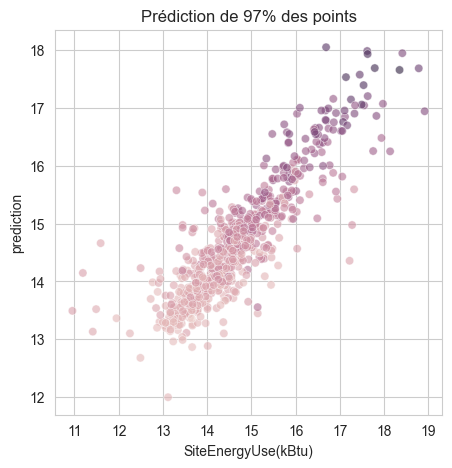

In [410]:
# Graphique de la target et de la prédiction
plt.figure(figsize = (5,5))
sns.scatterplot(data=pred, x="SiteEnergyUse(kBtu)", y="prediction",hue="PropertyGFATotal",
                legend=False,alpha=0.6)
plt.title('Prédiction de 97% des points')

In [411]:
coef =pd.DataFrame(data=gbr.feature_importances_,index=df_float.columns,columns=["coeff"])

coef["coeff_sort"] = coef["coeff"].abs()
coef = coef.sort_values(by="coeff_sort",ascending=False)
coef

,coeff,coeff_sort
PropertyGFATotal,0.740130,0.740130
PPT,0.085522,0.085522
tx_gaz,0.075684,0.075684
BulType,0.043241,0.043241
years,0.017562,0.017562
NumberofFloors,0.008366,0.008366
ThirdLargestPropertyUseTypeGFA,0.007856,0.007856
SecondLargestPropertyUseTypeGFA,0.007056,0.007056
Zip,0.006360,0.006360
Voisin,0.004766,0.004766


Text(0.5, 1.0, 'Coefficients de regression')

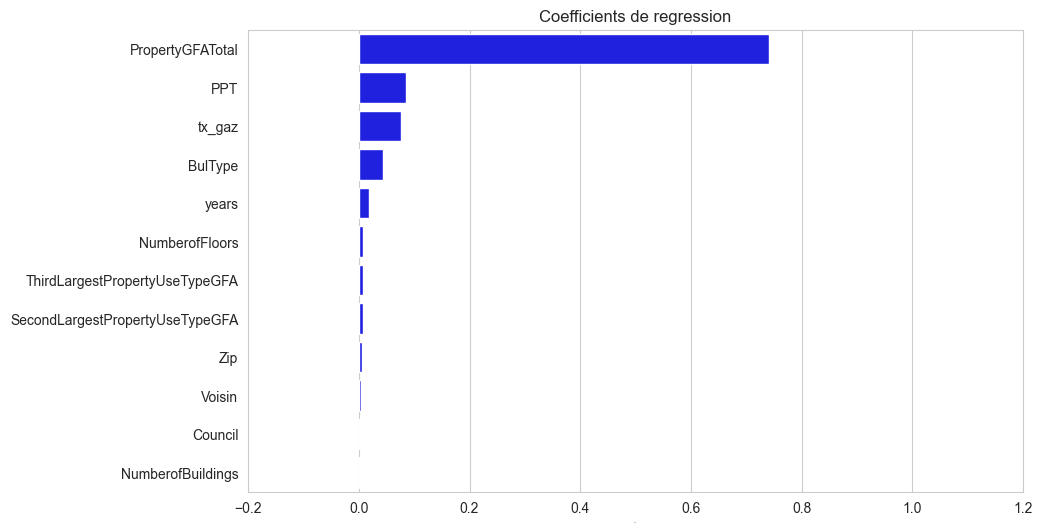

In [412]:
# Représentation graphique des coefficients

fig, ax = plt.subplots(figsize=(10, 6))
ax.set_xlim(-0.2, 1.2)
ax.set_xlabel( "",size=0 )
sns.barplot(x =coef.coeff  , y =coef.index ,data = coef , color = 'b',orient='h')
plt.setp(ax.get_yticklabels(),fontsize = 10)
plt.title("Coefficients de regression")

## 2.8) XGBoost sur données en log
<a class="anchor" id="Section_2.8"></a>

In [413]:
# Création de quatre DF: train et test
X_train, X_test, y_train, y_test = train_test_split(df_float_log, target_log,
                                                    test_size=0.2, random_state=0)

In [414]:
# Construction du modèle gradient boosting regressor

tps1 = time.time() # Temps d'execution

score ="r2"
xgb = xgboost.XGBRegressor()
parameters = { "max_depth":[3,5,7],
               'objective':['reg:squarederror'],
               "booster" :["gbtree"],
               "n_estimators" : [100],
                "n_jobs" : [2],
               'learning_rate': [0.03, 0.05, 0.07]}

model_xgb = GridSearchCV( estimator=xgb,
                          param_grid= parameters,
                          cv = 5,
                          scoring = score
                          )

model_xgb.fit(X_train,y_train)

tps2 = time.time()
temps_xgb = tps2 - tps1
print("Temps de calcul : ",temps_xgb,"s")

Temps de calcul :  8.245977640151978 s


In [415]:
# Afficher les performances correspondantes

result = "mean_test_score"
print("Résultats de la validation croisée :")
for mean, std, params in zip(
        model_xgb.cv_results_['mean_test_score'], # score moyen
        model_xgb.cv_results_['std_test_score'],  # écart-type du score
        model_xgb.cv_results_['params'] ):          # valeur de l'hyperparamètre

    print("{} = {:.3f} (+/-{:.03f}) for {}".format( result,
                                                   mean,
                                                   std*2,
                                                   params) )

Résultats de la validation croisée :
mean_test_score = 0.349 (+/-0.041) for {'booster': 'gbtree', 'learning_rate': 0.03, 'max_depth': 3, 'n_estimators': 100, 'n_jobs': 2, 'objective': 'reg:squarederror'}
mean_test_score = 0.365 (+/-0.051) for {'booster': 'gbtree', 'learning_rate': 0.03, 'max_depth': 5, 'n_estimators': 100, 'n_jobs': 2, 'objective': 'reg:squarederror'}
mean_test_score = 0.369 (+/-0.051) for {'booster': 'gbtree', 'learning_rate': 0.03, 'max_depth': 7, 'n_estimators': 100, 'n_jobs': 2, 'objective': 'reg:squarederror'}
mean_test_score = 0.733 (+/-0.047) for {'booster': 'gbtree', 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'n_jobs': 2, 'objective': 'reg:squarederror'}
mean_test_score = 0.745 (+/-0.049) for {'booster': 'gbtree', 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 100, 'n_jobs': 2, 'objective': 'reg:squarederror'}
mean_test_score = 0.747 (+/-0.043) for {'booster': 'gbtree', 'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 100, 'n_jobs

In [416]:
# Afficher le(s) hyperparamètre(s) optimaux
print("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:")
print(model_xgb.best_params_)

Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'booster': 'gbtree', 'learning_rate': 0.07, 'max_depth': 7, 'n_estimators': 100, 'n_jobs': 2, 'objective': 'reg:squarederror'}


### Métriques R2 & RMSE
### Représentation graphique des coefficients et du pouvoir prédictif du modèle

In [417]:
print("R2 sur le set d'apprentissage: ",model_xgb.score(X_train, y_train),"\n",
    "R2 sur le set de test: ",model_xgb.score(X_test, y_test))

R2 sur le set d'apprentissage:  0.91068889151422 
 R2 sur le set de test:  0.7662506811968735


In [418]:
xgb = xgboost.XGBRegressor(parametre=model_xgb.best_params_)
xgb.fit(X_train,y_train)

[14:58:06] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-030221e36e1a46bfb-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "parametre" } are not used.



XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.300000012, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1,
             parametre={'booster': 'gbtree', 'learning_rate': 0.07,
                        'max_depth': 7, 'n_estimators': 100, 'n_jobs': 2,
                        'objective': 'reg:squarederror'},
             predictor='auto', ...)

<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

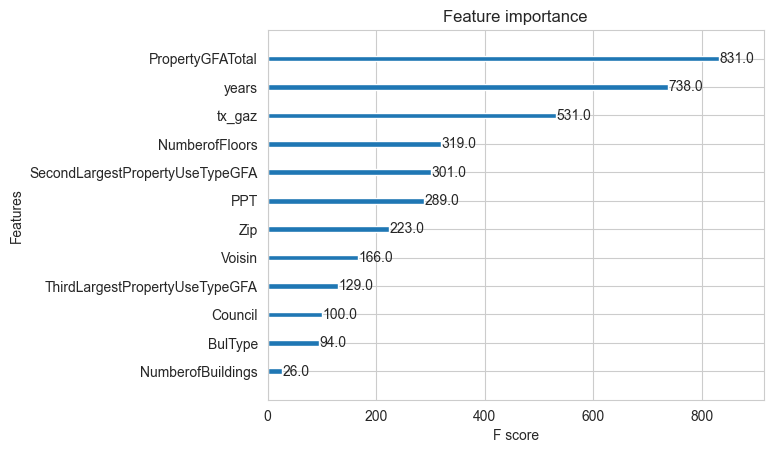

In [419]:
# Représentation graphique de l'importance de chaque variable
xgboost.plot_importance(xgb)

In [420]:
# Création d'un DF des valeurs prédites de X_test
pred = xgb.predict(X_test)
pred=pd.DataFrame(pred,columns=["prediction"])

# Affichage du RMSE
rmse(X_test,pred)

0.5689060074088137


In [421]:
# Création d'un DF composée de la target la prédiction et les résidus

y_xbg = y_test.merge(df_float_log["PropertyGFATotal"],how="left",left_index=True,right_index=True)
y_xbg = pd.DataFrame(y_xbg).reset_index()
y_xbg = y_xbg.drop(columns=["index"])
pred = pd.concat([y_xbg[["SiteEnergyUse(kBtu)","PropertyGFATotal"]],pred],axis=1)
pred["residus"]=pred["SiteEnergyUse(kBtu)"]-pred["prediction"]
pred

,SiteEnergyUse(kBtu),PropertyGFATotal,prediction,residus
0,13.344107,10.114397,13.822559,-0.478452
1,13.153030,9.945157,13.255216,-0.102185
2,14.587529,10.742336,14.833472,-0.245943
3,14.229982,10.924373,14.270279,-0.040297
4,14.282022,10.976645,15.084883,-0.802861
...,...,...,...,...
664,14.679065,10.945529,14.254221,0.424844
665,14.494171,11.547848,14.863973,-0.369801
666,13.895677,10.034296,13.968131,-0.072454
667,14.578931,10.651099,14.410495,0.168437


Text(0.5, 1.0, 'Prédiction de 97% des points')

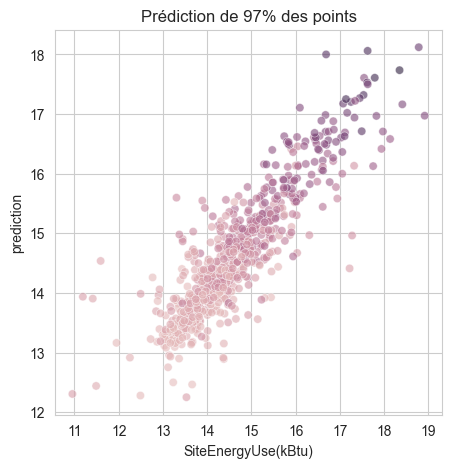

In [422]:
# Graphique de la target et de la prédiction
plt.figure(figsize = (5,5))
sns.scatterplot(data=pred, x="SiteEnergyUse(kBtu)", y="prediction",hue="PropertyGFATotal",
                legend=False,alpha=0.6)
plt.title('Prédiction de 97% des points')

## 2.9) Régression XGBoost avec la variable ENERGYSTARScore
<a class="anchor" id="Section_2.9"></a>

In [423]:
# On inclut la variable ENERGYscore ds le modèle
df_float["ENERGYSTARScore"]=df["ENERGYSTARScore"]
df_float_log = df_au_log(df_float)

In [424]:
# Imputation des données manquantes (ENERGYscore) par les KNN

imputer = KNNImputer(n_neighbors=5)

df_float_log = pd.DataFrame(data=imputer.fit_transform(df_float_log),
                            columns=df_float_log.columns)

In [425]:
# Création de quatre DF: train et test
X_train, X_test, y_train, y_test = train_test_split(df_float_log, target_log,
                                                    test_size=0.2, random_state=0)

In [426]:
# Construction du modèle gradient boosting regressor

tps1 = time.time() # Temps d'execution

score ="r2"
xgb = xgboost.XGBRegressor()
parameters = { "max_depth":[3,5,7],
               'objective':['reg:squarederror'],
               "booster" :["gbtree"],
               "n_estimators" : [100],
                "n_jobs" : [1],
               'learning_rate': [0.03, 0.05, 0.07]}

model_xgb = GridSearchCV( estimator=xgb,
                          param_grid= parameters,
                          cv = 5,
                          scoring = score
                          )

model_xgb.fit(X_train,y_train)

tps2 = time.time()
temps_xgb_E = tps2 - tps1
print("Temps de calcul : ",temps_xgb_E,"ms")

Temps de calcul :  12.024433851242065 ms


In [427]:
# Afficher les performances correspondantes

result = "mean_test_score"
print("Résultats de la validation croisée :")
for mean, std, params in zip(
        model_xgb.cv_results_['mean_test_score'], # score moyen
        model_xgb.cv_results_['std_test_score'],  # écart-type du score
        model_xgb.cv_results_['params'] ):          # valeur de l'hyperparamètre

    print("{} = {:.3f} (+/-{:.03f}) for {}".format( result,
                                                   mean,
                                                   std*2,
                                                   params) )

Résultats de la validation croisée :
mean_test_score = 0.375 (+/-0.039) for {'booster': 'gbtree', 'learning_rate': 0.03, 'max_depth': 3, 'n_estimators': 100, 'n_jobs': 1, 'objective': 'reg:squarederror'}
mean_test_score = 0.396 (+/-0.043) for {'booster': 'gbtree', 'learning_rate': 0.03, 'max_depth': 5, 'n_estimators': 100, 'n_jobs': 1, 'objective': 'reg:squarederror'}
mean_test_score = 0.398 (+/-0.049) for {'booster': 'gbtree', 'learning_rate': 0.03, 'max_depth': 7, 'n_estimators': 100, 'n_jobs': 1, 'objective': 'reg:squarederror'}
mean_test_score = 0.768 (+/-0.042) for {'booster': 'gbtree', 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'n_jobs': 1, 'objective': 'reg:squarederror'}
mean_test_score = 0.786 (+/-0.039) for {'booster': 'gbtree', 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 100, 'n_jobs': 1, 'objective': 'reg:squarederror'}
mean_test_score = 0.789 (+/-0.036) for {'booster': 'gbtree', 'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 100, 'n_jobs

In [428]:
# Afficher le(s) hyperparamètre(s) optimaux
print("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:")
print(model_xgb.best_params_)

Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'booster': 'gbtree', 'learning_rate': 0.07, 'max_depth': 7, 'n_estimators': 100, 'n_jobs': 1, 'objective': 'reg:squarederror'}


In [429]:
xgb = xgboost.XGBRegressor(parametre=model_xgb.best_params_)
xgb.fit(X_train,y_train)

[14:58:19] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-030221e36e1a46bfb-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "parametre" } are not used.



XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.300000012, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1,
             parametre={'booster': 'gbtree', 'learning_rate': 0.07,
                        'max_depth': 7, 'n_estimators': 100, 'n_jobs': 1,
                        'objective': 'reg:squarederror'},
             predictor='auto', ...)

<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

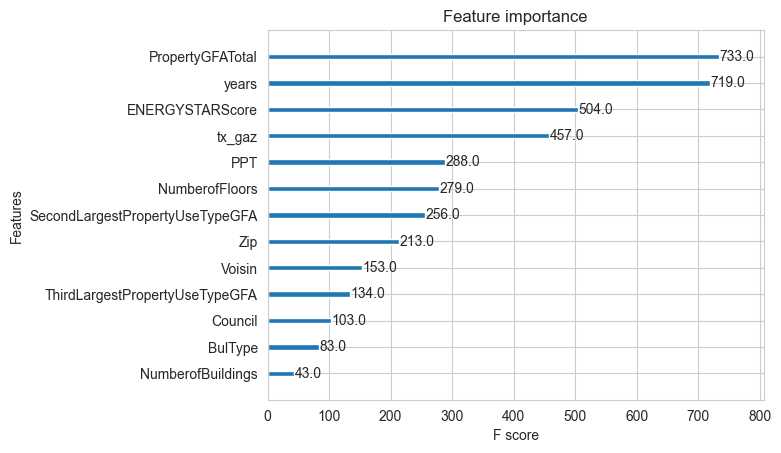

In [430]:
# Représentation graphique de l'importance de chaque variable
xgboost.plot_importance(xgb)

### Métriques R2 & RMSE
### Représentation graphique des coefficients et du pouvoir prédictif du modèle

In [431]:
print("R2 sur le set d'apprentissage: ",model_xgb.score(X_train, y_train),"\n",
    "R2 sur le set de test: ",model_xgb.score(X_test, y_test))

R2 sur le set d'apprentissage:  0.9409952543024837 
 R2 sur le set de test:  0.7970481882211841


In [432]:
# Création d'un DF des valeurs prédites de X_test
pred = model_xgb.predict(X_test)
pred=pd.DataFrame(pred,columns=["prediction"])

# Affichage du RMSE
rmse(X_test,pred)

0.5302613350345454


In [433]:
# Création d'un DF composée de la target la prédiction et les résidus

y_xgb_star = y_test.merge(df_float_log["PropertyGFATotal"],how="left",left_index=True,
                          right_index=True)
y_xgb_star = pd.DataFrame(y_xgb_star).reset_index()
y_xgb_star = y_xgb_star.drop(columns=["index"])
pred = pd.concat([y_xgb_star[["SiteEnergyUse(kBtu)","PropertyGFATotal"]],pred],axis=1)
pred["residus"]=pred["SiteEnergyUse(kBtu)"]-pred["prediction"]
pred

,SiteEnergyUse(kBtu),PropertyGFATotal,prediction,residus
0,13.344107,10.542099,13.741178,-0.397071
1,13.153030,10.249804,13.309576,-0.156546
2,14.587529,11.100496,14.699997,-0.112468
3,14.229982,11.021183,14.150829,0.079153
4,14.282022,11.099423,15.263186,-0.981163
...,...,...,...,...
664,14.679065,11.438116,14.796553,-0.117488
665,14.494171,10.007622,14.786350,-0.292179
666,13.895677,11.060212,13.862357,0.033320
667,14.578931,9.980449,14.361473,0.217458


<AxesSubplot: xlabel='SiteEnergyUse(kBtu)', ylabel='prediction'>

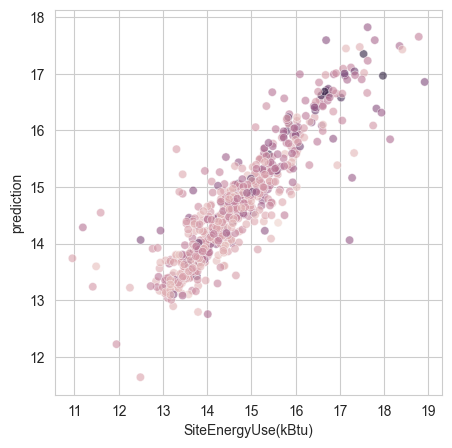

In [434]:
# Graphique de la target et de la prédiction
plt.figure(figsize = (5,5))
sns.scatterplot(data=pred, x="SiteEnergyUse(kBtu)", y="prediction",hue="PropertyGFATotal",
                legend=False,alpha=0.6)

## Conclusion partie 2
<a class="anchor" id="Conclusion"></a>

# 📄 References<a class="anchor" id="Références"></a>
- [Data Seattle](https://data.seattle.gov/dataset/2016-Building-Energy-Benchmarking/2bpz-gwpy)
- [Librairie Pandas](https://pandas.pydata.org/docs/user_guide/index.html#)
- [Librairie scikit-learn](https://scikit-learn.org/stable/user_guide.html)
- [Librairie XGBoost](https://xgboost.readthedocs.io/en/latest/python/python_api.html)